In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

# =============================================================================
# A1. FUNCTION MODULES
# =============================================================================

# a) Summation Unit
def summation_unit(inputs, weights, bias):
    """
    Calculates the weighted sum of inputs for a neuron.
    y = sum(w_i * x_i) + bias
    """
    return np.dot(inputs, weights) + bias

# b) Activation Units
def step_activation(net_input):
    """Step activation function."""
    return 1.0 if net_input >= 0 else 0.0

def bipolar_step_activation(net_input):
    """Bipolar Step activation function."""
    if net_input > 0:
        return 1.0
    elif net_input < 0:
        return -1.0
    return 0.0

def sigmoid_activation(net_input):
    """Sigmoid activation function."""
    return 1.0 / (1.0 + np.exp(-net_input))

def tanh_activation(net_input):
    """Hyperbolic Tangent (TanH) activation function."""
    return np.tanh(net_input)

def relu_activation(net_input):
    """ReLU (Rectified Linear Unit) activation function."""
    return max(0.0, net_input)

def leaky_relu_activation(net_input, alpha=0.01):
    """Leaky ReLU activation function."""
    return net_input if net_input > 0 else alpha * net_input

# c) Comparator unit for Error calculation
def calculate_error(target, actual):
    """Calculates the error (target - actual)."""
    return target - actual

# =============================================================================
# A2, A3, A4, A5, A6, A9 - PERCEPTRON TRAINING FUNCTION
# =============================================================================

def train_perceptron(training_data, initial_weights, initial_bias, learning_rate, activation_func, max_epochs=1000, convergence_error=0.002):
    """
    Trains a single-layer perceptron.
    
    Returns:
        final_weights: The converged weights.
        final_bias: The converged bias.
        epochs_converged: The number of epochs for convergence.
        error_history: A list of sum-squared errors for each epoch.
    """
    weights = np.array(initial_weights)
    bias = initial_bias
    error_history = []
    
    for epoch in range(max_epochs):
        sum_squared_error = 0
        
        # Separate inputs and targets
        inputs = training_data[:, :-1]
        targets = training_data[:, -1]
        
        for i in range(len(inputs)):
            # Calculate net input and activate
            net_input = summation_unit(inputs[i], weights, bias)
            actual_output = activation_func(net_input)
            
            # Calculate error
            error = calculate_error(targets[i], actual_output)
            
            # Update weights and bias
            weights += learning_rate * error * inputs[i]
            bias += learning_rate * error
            
            # Add to sum-squared error for the epoch
            sum_squared_error += error**2
            
        error_history.append(sum_squared_error)
        
        # Check for convergence
        if sum_squared_error <= convergence_error:
            return weights, bias, epoch + 1, error_history
            
    # Return if max epochs reached without convergence
    return weights, bias, max_epochs, error_history


# =============================================================================
# A7. MATRIX PSEUDO-INVERSE FUNCTION
# =============================================================================
def calculate_pseudo_inverse_weights(X, T):
    """
    Calculates weights using the matrix pseudo-inverse method.
    X must have a column of 1s for the bias.
    """
    try:
        # W = (X^T * X)^-1 * X^T * T
        weights = np.linalg.inv(X.T @ X) @ X.T @ T
        return weights
    except np.linalg.LinAlgError:
        # Use numpy's pinv for a more stable calculation if matrix is singular
        return np.linalg.pinv(X) @ T
        

# =============================================================================
# A8. BACKPROPAGATION TRAINING FUNCTION
# =============================================================================

def train_backpropagation_network(training_data, n_hidden, learning_rate, max_epochs=1000, convergence_error=0.002):
    """
    Trains a 2-layer neural network (1 hidden layer) using backpropagation.
    Assumes Sigmoid activation for all neurons.
    """
    n_inputs = training_data.shape[1] - 1
    n_outputs = 1 # For AND/XOR gate
    
    # Initialize weights and biases with small random numbers
    hidden_weights = np.random.uniform(-0.05, 0.05, size=(n_inputs, n_hidden))
    hidden_bias = np.random.uniform(-0.05, 0.05, size=(1, n_hidden))
    output_weights = np.random.uniform(-0.05, 0.05, size=(n_hidden, n_outputs))
    output_bias = np.random.uniform(-0.05, 0.05, size=(1, n_outputs))
    
    error_history = []

    for epoch in range(max_epochs):
        sum_squared_error = 0
        inputs = training_data[:, :-1]
        targets = training_data[:, -1].reshape(-1, 1)

        for i in range(len(inputs)):
            X = inputs[i:i+1] # Keep it as a 2D array
            T = targets[i:i+1]

            # === Forward Propagation ===
            # Hidden layer
            hidden_layer_input = np.dot(X, hidden_weights) + hidden_bias
            hidden_layer_output = sigmoid_activation(hidden_layer_input)
            
            # Output layer
            output_layer_input = np.dot(hidden_layer_output, output_weights) + output_bias
            predicted_output = sigmoid_activation(output_layer_input)
            
            # === Backward Propagation ===
            # Calculate error
            error = T - predicted_output
            sum_squared_error += error**2

            # [cite_start]Calculate error terms (deltas) [cite: 115, 117]
            # Output layer delta
            delta_output = error * predicted_output * (1 - predicted_output)
            
            # Hidden layer delta
            error_hidden_layer = delta_output.dot(output_weights.T)
            delta_hidden = error_hidden_layer * hidden_layer_output * (1 - hidden_layer_output)
            
            # [cite_start]=== Update Weights and Biases === [cite: 121, 122]
            # Output layer
            output_weights += hidden_layer_output.T.dot(delta_output) * learning_rate
            output_bias += np.sum(delta_output, axis=0, keepdims=True) * learning_rate
            
            # Hidden layer
            hidden_weights += X.T.dot(delta_hidden) * learning_rate
            hidden_bias += np.sum(delta_hidden, axis=0, keepdims=True) * learning_rate

        error_history.append(sum_squared_error.item())
        
        if sum_squared_error <= convergence_error:
            return hidden_weights, output_weights, epoch + 1, error_history
            
    return hidden_weights, output_weights, max_epochs, error_history

# =============================================================================
# MAIN EXECUTION BLOCK
# =============================================================================

if __name__ == "__main__":
    
    # --- Data Definitions ---
    # [cite_start]AND Gate Data [cite: 17]
    and_gate_data = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 1, 1]
    ])
    
    # [cite_start]XOR Gate Data [cite: 23]
    xor_gate_data = np.array([
        [0, 0, 0],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]
    ])

    # [cite_start]Customer Data [cite: 85]
    # Features: Candies, Mangoes, Milk Packets, Payment
    # Target: High Value Tx? (1 for Yes, 0 for No)
    customer_data = np.array([
        [20, 6, 2, 386, 1],
        [16, 3, 6, 289, 1],
        [27, 6, 2, 393, 1],
        [19, 1, 2, 110, 0],
        [24, 4, 2, 280, 1],
        [22, 1, 5, 167, 0],
        [15, 4, 2, 271, 1],
        [18, 4, 2, 274, 1],
        [21, 1, 4, 148, 0],
        [16, 2, 4, 198, 0]
    ])

    print("======================================================")
    print("A2: Perceptron for AND Gate with Step Activation")
    print("======================================================")
    
    # [cite_start]Initial parameters from document [cite: 37]
    initial_weights_A2 = [0.2, -0.75]
    initial_bias_A2 = 10
    learning_rate_A2 = 0.05
    
    final_w, final_b, epochs, errors = train_perceptron(
        and_gate_data,
        initial_weights_A2,
        initial_bias_A2,
        learning_rate_A2,
        step_activation
    )
    
    print(f"Convergence reached after {epochs} epochs.")
    print(f"Final Weights: {final_w}")
    print(f"Final Bias: {final_b}")
    
    # [cite_start]Plotting for A2 [cite: 49]
    plt.figure()
    plt.plot(range(1, epochs + 1), errors)
    plt.title("A2: Error Convergence for AND Gate (Step Activation)")
    plt.xlabel("Epochs")
    plt.ylabel("Sum-Squared Error")
    plt.grid(True)
    plt.show()

    print("\n======================================================")
    print("A3: AND Gate with Other Activation Functions")
    print("======================================================")

    # Bi-Polar Step Function (Note: Targets must be adjusted to -1/1)
    and_gate_bipolar_data = np.where(and_gate_data.copy()[:, -1] == 0, -1, 1)
    and_gate_bipolar_data = np.hstack((and_gate_data[:, :-1], and_gate_bipolar_data.reshape(-1, 1)))
    _, _, epochs_bipolar, _ = train_perceptron(and_gate_bipolar_data, initial_weights_A2, initial_bias_A2, learning_rate_A2, bipolar_step_activation)
    print(f"Bi-Polar Step Function converged in {epochs_bipolar} epochs.")
    
    # Sigmoid Function
    _, _, epochs_sigmoid, _ = train_perceptron(and_gate_data, initial_weights_A2, initial_bias_A2, learning_rate_A2, sigmoid_activation)
    print(f"Sigmoid Function converged in {epochs_sigmoid} epochs.")

    # ReLU Function
    _, _, epochs_relu, _ = train_perceptron(and_gate_data, initial_weights_A2, initial_bias_A2, learning_rate_A2, relu_activation)
    print(f"ReLU Function converged in {epochs_relu} epochs.")

    print("\n======================================================")
    print("A4: Varying Learning Rate for AND Gate")
    print("======================================================")
    
    learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    epochs_per_rate = []
    
    for rate in learning_rates:
        _, _, epochs, _ = train_perceptron(and_gate_data, initial_weights_A2, initial_bias_A2, rate, step_activation)
        epochs_per_rate.append(epochs)
        
    # [cite_start]Plotting for A4 [cite: 80]
    plt.figure()
    plt.plot(learning_rates, epochs_per_rate, marker='o')
    plt.title("A4: Epochs vs. Learning Rate for AND Gate")
    plt.xlabel("Learning Rate")
    plt.ylabel("Epochs to Converge")
    plt.grid(True)
    plt.show()
    
    print("Epochs for each learning rate:", epochs_per_rate)


    print("\n======================================================")
    print("A5 & A9: Perceptron for XOR Gate")
    print("======================================================")
    print("A single-layer perceptron cannot solve XOR as it's not linearly separable.")
    print("The training is expected to run for the maximum number of epochs.")
    
    _, _, epochs_xor, _ = train_perceptron(
        xor_gate_data,
        initial_weights_A2,
        initial_bias_A2,
        learning_rate_A2,
        step_activation
    )
    print(f"XOR Gate training with Step Activation ran for {epochs_xor} epochs.")


    print("\n======================================================")
    print("A6: Perceptron for Customer Data")
    print("======================================================")

    # Normalize payment feature for better training performance
    customer_data_norm = customer_data.copy().astype(float)
    customer_data_norm[:, 3] /= np.max(customer_data_norm[:, 3]) # Normalize payment column

    # Initialize with random weights and a chosen learning rate
    initial_weights_A6 = np.random.rand(4) 
    initial_bias_A6 = np.random.rand()
    learning_rate_A6 = 0.1
    
    w_cust, b_cust, epochs_cust, _ = train_perceptron(
        customer_data_norm,
        initial_weights_A6,
        initial_bias_A6,
        learning_rate_A6,
        sigmoid_activation
    )
    
    print(f"Customer data classification converged in {epochs_cust} epochs.")
    print(f"Final Weights: {w_cust}")
    print(f"Final Bias: {b_cust}")

    print("\n======================================================")
    print("A7: Comparison with Matrix Pseudo-Inverse")
    print("======================================================")
    
    # Prepare data for pseudo-inverse
    X_cust = customer_data_norm[:, :-1]
    # Add a column of ones for the bias term
    X_cust_bias = np.hstack([np.ones((X_cust.shape[0], 1)), X_cust])
    T_cust = customer_data_norm[:, -1]
    
    weights_pseudo_inv = calculate_pseudo_inverse_weights(X_cust_bias, T_cust)
    
    print(f"Weights from Pseudo-Inverse: {weights_pseudo_inv}")
    print("Note: The first weight corresponds to the bias.")

    print("\n======================================================")
    print("A8: Backpropagation for AND Gate")
    print("======================================================")

    _, _, epochs_bp, errors_bp = train_backpropagation_network(
        and_gate_data, 
        n_hidden=2, 
        learning_rate=0.05
    )

    print(f"Backpropagation for AND gate converged in {epochs_bp} epochs.")
    
    plt.figure()
    plt.plot(errors_bp)
    plt.title("A8: Error Convergence for AND Gate (Backpropagation)")
    plt.xlabel("Epochs")
    plt.ylabel("Sum-Squared Error")
    plt.grid(True)
    plt.show()

    print("\n======================================================")
    print("A11: Using scikit-learn's MLPClassifier")
    print("======================================================")

    # --- AND Gate with MLPClassifier ---
    X_and = and_gate_data[:, :2]
    y_and = and_gate_data[:, 2]
    
    mlp_and = MLPClassifier(hidden_layer_sizes=(2,), activation='logistic', solver='sgd', learning_rate_init=0.05, max_iter=1000, random_state=1)
    mlp_and.fit(X_and, y_and)
    print("MLPClassifier predictions for AND Gate:", mlp_and.predict(X_and))

    # --- XOR Gate with MLPClassifier ---
    X_xor = xor_gate_data[:, :2]
    y_xor = xor_gate_data[:, 2]
    
    # MLP can solve XOR
    mlp_xor = MLPClassifier(hidden_layer_sizes=(2,), activation='logistic', solver='sgd', learning_rate_init=0.1, max_iter=2000, random_state=1)
    mlp_xor.fit(X_xor, y_xor)
    print("MLPClassifier predictions for XOR Gate:", mlp_xor.predict(X_xor))

    print("\n======================================================")
    print("A12: MLPClassifier on Project (Customer) Dataset")
    print("======================================================")

    X_cust_mlp = customer_data_norm[:, :-1]
    y_cust_mlp = customer_data[:, -1] # Use original 0/1 targets

    mlp_cust = MLPClassifier(hidden_layer_sizes=(5, 2), max_iter=1000, random_state=1)
    mlp_cust.fit(X_cust_mlp, y_cust_mlp)
    
    print("MLPClassifier predictions for Customer Data:", mlp_cust.predict(X_cust_mlp))
    print("Actual Customer Data Targets:         ", y_cust_mlp)
    print(f"Model Accuracy: {mlp_cust.score(X_cust_mlp, y_cust_mlp) * 100:.2f}%")

A2: Perceptron for AND Gate with Step Activation
Convergence reached after 130 epochs.
Final Weights: [0.1  0.05]
Final Bias: -0.10000000000000765


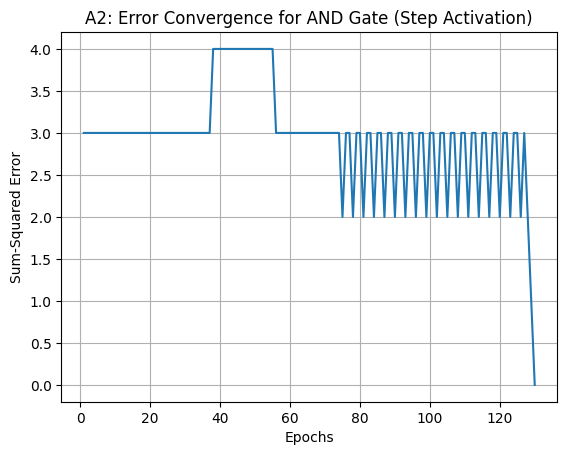


A3: AND Gate with Other Activation Functions
Bi-Polar Step Function converged in 68 epochs.
Sigmoid Function converged in 1000 epochs.
ReLU Function converged in 390 epochs.

A4: Varying Learning Rate for AND Gate


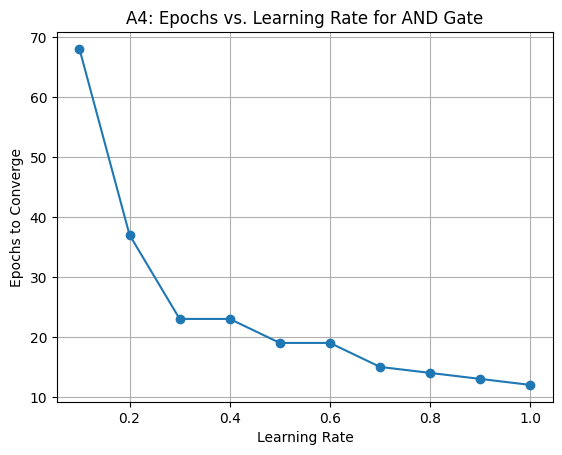

Epochs for each learning rate: [68, 37, 23, 23, 19, 19, 15, 14, 13, 12]

A5 & A9: Perceptron for XOR Gate
A single-layer perceptron cannot solve XOR as it's not linearly separable.
The training is expected to run for the maximum number of epochs.
XOR Gate training with Step Activation ran for 1000 epochs.

A6: Perceptron for Customer Data
Customer data classification converged in 19 epochs.
Final Weights: [-1.68651253 11.04151242 -0.39231054  1.99658661]
Final Bias: 0.6872046897369684

A7: Comparison with Matrix Pseudo-Inverse
Weights from Pseudo-Inverse: [ 0.1139903  -0.02352173  0.25549997  0.03556254  0.03732596]
Note: The first weight corresponds to the bias.

A8: Backpropagation for AND Gate
Backpropagation for AND gate converged in 1000 epochs.


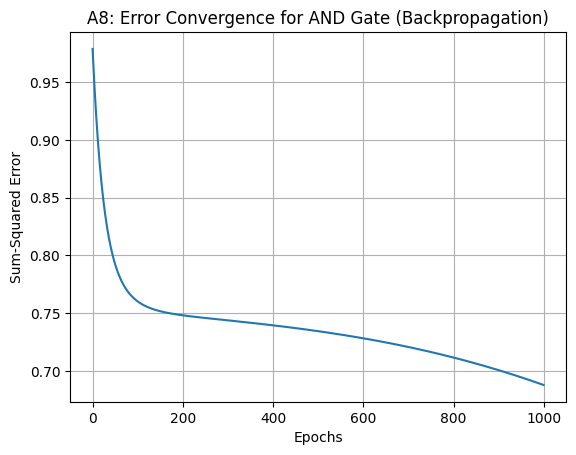


A11: Using scikit-learn's MLPClassifier
MLPClassifier predictions for AND Gate: [0 0 0 1]
MLPClassifier predictions for XOR Gate: [1 1 1 1]

A12: MLPClassifier on Project (Customer) Dataset
MLPClassifier predictions for Customer Data: [1 1 1 1 1 1 1 1 1 1]
Actual Customer Data Targets:          [1 1 1 0 1 0 1 1 0 0]
Model Accuracy: 60.00%


In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

# =============================================================================
# A1. FUNCTION MODULES
# =============================================================================

# a) Summation Unit
def summation_unit(inputs, weights, bias):
    """
    Calculates the weighted sum of inputs for a neuron.
    y = sum(w_i * x_i) + bias
    """
    return np.dot(inputs, weights) + bias

# b) Activation Units
def step_activation(net_input):
    """Step activation function."""
    return 1.0 if net_input >= 0 else 0.0

def bipolar_step_activation(net_input):
    """Bipolar Step activation function."""
    if net_input > 0:
        return 1.0
    elif net_input < 0:
        return -1.0
    return 0.0

def sigmoid_activation(net_input):
    """Sigmoid activation function."""
    return 1.0 / (1.0 + np.exp(-net_input))

def tanh_activation(net_input):
    """Hyperbolic Tangent (TanH) activation function."""
    return np.tanh(net_input)

def relu_activation(net_input):
    """ReLU (Rectified Linear Unit) activation function."""
    return max(0.0, net_input)

def leaky_relu_activation(net_input, alpha=0.01):
    """Leaky ReLU activation function."""
    return net_input if net_input > 0 else alpha * net_input

# c) Comparator unit for Error calculation
def calculate_error(target, actual):
    """Calculates the error (target - actual)."""
    return target - actual

# =============================================================================
# A2, A3, A4, A5, A6, A9 - PERCEPTRON TRAINING FUNCTION
# =============================================================================

def train_perceptron(training_data, initial_weights, initial_bias, learning_rate, activation_func, max_epochs=1000, convergence_error=0.002):
    """
    Trains a single-layer perceptron.
    
    Returns:
        final_weights: The converged weights.
        final_bias: The converged bias.
        epochs_converged: The number of epochs for convergence.
        error_history: A list of sum-squared errors for each epoch.
    """
    weights = np.array(initial_weights)
    bias = initial_bias
    error_history = []
    
    for epoch in range(max_epochs):
        sum_squared_error = 0
        
        # Separate inputs and targets
        inputs = training_data[:, :-1]
        targets = training_data[:, -1]
        
        for i in range(len(inputs)):
            # Calculate net input and activate
            net_input = summation_unit(inputs[i], weights, bias)
            actual_output = activation_func(net_input)
            
            # Calculate error
            error = calculate_error(targets[i], actual_output)
            
            # Update weights and bias
            weights += learning_rate * error * inputs[i]
            bias += learning_rate * error
            
            # Add to sum-squared error for the epoch
            sum_squared_error += error**2
            
        error_history.append(sum_squared_error)
        
        # Check for convergence
        if sum_squared_error <= convergence_error:
            return weights, bias, epoch + 1, error_history
            
    # Return if max epochs reached without convergence
    return weights, bias, max_epochs, error_history


# =============================================================================
# A7. MATRIX PSEUDO-INVERSE FUNCTION
# =============================================================================
def calculate_pseudo_inverse_weights(X, T):
    """
    Calculates weights using the matrix pseudo-inverse method.
    X must have a column of 1s for the bias.
    """
    try:
        # W = (X^T * X)^-1 * X^T * T
        weights = np.linalg.inv(X.T @ X) @ X.T @ T
        return weights
    except np.linalg.LinAlgError:
        # Use numpy's pinv for a more stable calculation if matrix is singular
        return np.linalg.pinv(X) @ T
        

# =============================================================================
# A8. BACKPROPAGATION TRAINING FUNCTION
# =============================================================================

def train_backpropagation_network(training_data, n_hidden, learning_rate, max_epochs=1000, convergence_error=0.002):
    """
    Trains a 2-layer neural network (1 hidden layer) using backpropagation.
    Assumes Sigmoid activation for all neurons.
    """
    n_inputs = training_data.shape[1] - 1
    n_outputs = 1 # For AND/XOR gate
    
    # Initialize weights and biases with small random numbers
    hidden_weights = np.random.uniform(-0.05, 0.05, size=(n_inputs, n_hidden))
    hidden_bias = np.random.uniform(-0.05, 0.05, size=(1, n_hidden))
    output_weights = np.random.uniform(-0.05, 0.05, size=(n_hidden, n_outputs))
    output_bias = np.random.uniform(-0.05, 0.05, size=(1, n_outputs))
    
    error_history = []

    for epoch in range(max_epochs):
        sum_squared_error = 0
        inputs = training_data[:, :-1]
        targets = training_data[:, -1].reshape(-1, 1)

        for i in range(len(inputs)):
            X = inputs[i:i+1] # Keep it as a 2D array
            T = targets[i:i+1]

            # === Forward Propagation ===
            # Hidden layer
            hidden_layer_input = np.dot(X, hidden_weights) + hidden_bias
            hidden_layer_output = sigmoid_activation(hidden_layer_input)
            
            # Output layer
            output_layer_input = np.dot(hidden_layer_output, output_weights) + output_bias
            predicted_output = sigmoid_activation(output_layer_input)
            
            # === Backward Propagation ===
            # Calculate error
            error = T - predicted_output
            sum_squared_error += error**2

            # [cite_start]Calculate error terms (deltas) [cite: 115, 117]
            # Output layer delta
            delta_output = error * predicted_output * (1 - predicted_output)
            
            # Hidden layer delta
            error_hidden_layer = delta_output.dot(output_weights.T)
            delta_hidden = error_hidden_layer * hidden_layer_output * (1 - hidden_layer_output)
            
            # [cite_start]=== Update Weights and Biases === [cite: 121, 122]
            # Output layer
            output_weights += hidden_layer_output.T.dot(delta_output) * learning_rate
            output_bias += np.sum(delta_output, axis=0, keepdims=True) * learning_rate
            
            # Hidden layer
            hidden_weights += X.T.dot(delta_hidden) * learning_rate
            hidden_bias += np.sum(delta_hidden, axis=0, keepdims=True) * learning_rate

        error_history.append(sum_squared_error.item())
        
        if sum_squared_error <= convergence_error:
            return hidden_weights, output_weights, epoch + 1, error_history
            
    return hidden_weights, output_weights, max_epochs, error_history

# =============================================================================
# MAIN EXECUTION BLOCK
# =============================================================================

if __name__ == "__main__":
    
    # --- Data Definitions ---
    # [cite_start]AND Gate Data [cite: 17]
    and_gate_data = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 1, 1]
    ])
    
    # [cite_start]XOR Gate Data [cite: 23]
    xor_gate_data = np.array([
        [0, 0, 0],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]
    ])

    # [cite_start]Customer Data [cite: 85]
    # Features: Candies, Mangoes, Milk Packets, Payment
    # Target: High Value Tx? (1 for Yes, 0 for No)
    customer_data = np.array([
        [20, 6, 2, 386, 1],
        [16, 3, 6, 289, 1],
        [27, 6, 2, 393, 1],
        [19, 1, 2, 110, 0],
        [24, 4, 2, 280, 1],
        [22, 1, 5, 167, 0],
        [15, 4, 2, 271, 1],
        [18, 4, 2, 274, 1],
        [21, 1, 4, 148, 0],
        [16, 2, 4, 198, 0]
    ])

    print("======================================================")
    print("A2: Perceptron for AND Gate with Step Activation")
    print("======================================================")
    
    # [cite_start]Initial parameters from document [cite: 37]
    initial_weights_A2 = [0.2, -0.75]
    initial_bias_A2 = 10
    learning_rate_A2 = 0.05
    
    final_w, final_b, epochs, errors = train_perceptron(
        and_gate_data,
        initial_weights_A2,
        initial_bias_A2,
        learning_rate_A2,
        step_activation
    )
    
    print(f"Convergence reached after {epochs} epochs.")
    print(f"Final Weights: {final_w}")
    print(f"Final Bias: {final_b}")
    
    # [cite_start]Plotting for A2 [cite: 49]
    plt.figure()
    plt.plot(range(1, epochs + 1), errors)
    plt.title("A2: Error Convergence for AND Gate (Step Activation)")
    plt.xlabel("Epochs")
    plt.ylabel("Sum-Squared Error")
    plt.grid(True)
    plt.show()

    print("\n======================================================")
    print("A3: AND Gate with Other Activation Functions")
    print("======================================================")

    # Bi-Polar Step Function (Note: Targets must be adjusted to -1/1)
    and_gate_bipolar_data = np.where(and_gate_data.copy()[:, -1] == 0, -1, 1)
    and_gate_bipolar_data = np.hstack((and_gate_data[:, :-1], and_gate_bipolar_data.reshape(-1, 1)))
    _, _, epochs_bipolar, _ = train_perceptron(and_gate_bipolar_data, initial_weights_A2, initial_bias_A2, learning_rate_A2, bipolar_step_activation)
    print(f"Bi-Polar Step Function converged in {epochs_bipolar} epochs.")
    
    # Sigmoid Function
    _, _, epochs_sigmoid, _ = train_perceptron(and_gate_data, initial_weights_A2, initial_bias_A2, learning_rate_A2, sigmoid_activation)
    print(f"Sigmoid Function converged in {epochs_sigmoid} epochs.")

    # ReLU Function
    _, _, epochs_relu, _ = train_perceptron(and_gate_data, initial_weights_A2, initial_bias_A2, learning_rate_A2, relu_activation)
    print(f"ReLU Function converged in {epochs_relu} epochs.")

    print("\n======================================================")
    print("A4: Varying Learning Rate for AND Gate")
    print("======================================================")
    
    learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    epochs_per_rate = []
    
    for rate in learning_rates:
        _, _, epochs, _ = train_perceptron(and_gate_data, initial_weights_A2, initial_bias_A2, rate, step_activation)
        epochs_per_rate.append(epochs)
        
    # [cite_start]Plotting for A4 [cite: 80]
    plt.figure()
    plt.plot(learning_rates, epochs_per_rate, marker='o')
    plt.title("A4: Epochs vs. Learning Rate for AND Gate")
    plt.xlabel("Learning Rate")
    plt.ylabel("Epochs to Converge")
    plt.grid(True)
    plt.show()
    
    print("Epochs for each learning rate:", epochs_per_rate)


    print("\n======================================================")
    print("A5 & A9: Perceptron for XOR Gate")
    print("======================================================")
    print("A single-layer perceptron cannot solve XOR as it's not linearly separable.")
    print("The training is expected to run for the maximum number of epochs.")
    
    _, _, epochs_xor, _ = train_perceptron(
        xor_gate_data,
        initial_weights_A2,
        initial_bias_A2,
        learning_rate_A2,
        step_activation
    )
    print(f"XOR Gate training with Step Activation ran for {epochs_xor} epochs.")


    print("\n======================================================")
    print("A6: Perceptron for Customer Data")
    print("======================================================")

    # Normalize payment feature for better training performance
    customer_data_norm = customer_data.copy().astype(float)
    customer_data_norm[:, 3] /= np.max(customer_data_norm[:, 3]) # Normalize payment column

    # Initialize with random weights and a chosen learning rate
    initial_weights_A6 = np.random.rand(4) 
    initial_bias_A6 = np.random.rand()
    learning_rate_A6 = 0.1
    
    w_cust, b_cust, epochs_cust, _ = train_perceptron(
        customer_data_norm,
        initial_weights_A6,
        initial_bias_A6,
        learning_rate_A6,
        sigmoid_activation
    )
    
    print(f"Customer data classification converged in {epochs_cust} epochs.")
    print(f"Final Weights: {w_cust}")
    print(f"Final Bias: {b_cust}")

    print("\n======================================================")
    print("A7: Comparison with Matrix Pseudo-Inverse")
    print("======================================================")
    
    # Prepare data for pseudo-inverse
    X_cust = customer_data_norm[:, :-1]
    # Add a column of ones for the bias term
    X_cust_bias = np.hstack([np.ones((X_cust.shape[0], 1)), X_cust])
    T_cust = customer_data_norm[:, -1]
    
    weights_pseudo_inv = calculate_pseudo_inverse_weights(X_cust_bias, T_cust)
    
    print(f"Weights from Pseudo-Inverse: {weights_pseudo_inv}")
    print("Note: The first weight corresponds to the bias.")

    print("\n======================================================")
    print("A8: Backpropagation for AND Gate")
    print("======================================================")

    _, _, epochs_bp, errors_bp = train_backpropagation_network(
        and_gate_data, 
        n_hidden=2, 
        learning_rate=0.05
    )

    print(f"Backpropagation for AND gate converged in {epochs_bp} epochs.")
    
    plt.figure()
    plt.plot(errors_bp)
    plt.title("A8: Error Convergence for AND Gate (Backpropagation)")
    plt.xlabel("Epochs")
    plt.ylabel("Sum-Squared Error")
    plt.grid(True)
    plt.show()

    print("\n======================================================")
    print("A11: Using scikit-learn's MLPClassifier")
    print("======================================================")

    # --- AND Gate with MLPClassifier ---
    X_and = and_gate_data[:, :2]
    y_and = and_gate_data[:, 2]
    
    mlp_and = MLPClassifier(hidden_layer_sizes=(2,), activation='logistic', solver='sgd', learning_rate_init=0.05, max_iter=1000, random_state=1)
    mlp_and.fit(X_and, y_and)
    print("MLPClassifier predictions for AND Gate:", mlp_and.predict(X_and))

    # --- XOR Gate with MLPClassifier ---
    X_xor = xor_gate_data[:, :2]
    y_xor = xor_gate_data[:, 2]
    
    # MLP can solve XOR
    mlp_xor = MLPClassifier(hidden_layer_sizes=(2,), activation='logistic', solver='sgd', learning_rate_init=0.1, max_iter=2000, random_state=1)
    mlp_xor.fit(X_xor, y_xor)
    print("MLPClassifier predictions for XOR Gate:", mlp_xor.predict(X_xor))

    print("\n======================================================")
    print("A12: MLPClassifier on Project (Customer) Dataset")
    print("======================================================")

    X_cust_mlp = customer_data_norm[:, :-1]
    y_cust_mlp = customer_data[:, -1] # Use original 0/1 targets


    mlp_cust = MLPClassifier(hidden_layer_sizes=(5, 2), max_iter=1000, random_state=1)
    mlp_cust.fit(X_cust_mlp, y_cust_mlp)
    
    print("MLPClassifier predictions for Customer Data:", mlp_cust.predict(X_cust_mlp))
    print("Actual Customer Data Targets:         ", y_cust_mlp)
    print(f"Model Accuracy: {mlp_cust.score(X_cust_mlp, y_cust_mlp) * 100:.2f}%")